In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os.path

DATA_DIR = "data/"
DATA_PROC_DIR = "data-processed/"
ATAC_SEQ_PATH = os.path.join(DATA_DIR, "ImmGenATAC18_AllOCRsInfo.csv")
REFFLAT_PATH = os.path.join(DATA_DIR, "refFlat.txt.gz")
PROC_PEAKS_PATH = os.path.join(DATA_PROC_DIR, "peaks_annotated.csv")

# Load ATAC-seq data
atac = pd.read_csv(ATAC_SEQ_PATH, index_col=[0,1,2])
atac.index.names = ["id","chrom","summit"]
peaks = atac.reset_index()
# Load gene annotation data
refFlat = pd.read_csv(REFFLAT_PATH, sep="\t", header=None, compression="gzip")
refFlat.columns = ["geneName", "transcriptName", "chrom", "strand", "tx5p", "tx3p",
    "cdsStart", "cdsEnd", "exonCount", "exonStarts", "exonEnds"]

#atac[atac["TSS"].notna()]

In [ ]:
# Check if pre-processed peaks exist if not generate them
if not os.path.exists(PROC_PEAKS_PATH):
    # Compute TSS for each transcript:
    # If strand == "+", TSS = tx5p; if "-", TSS = tx3p
    refFlat["tss"] = np.where(refFlat["strand"] == "+",
                            refFlat["tx5p"],
                            refFlat["tx3p"])

    # Build a dict of sorted TSS positions per chromosome
    tss_by_chrom = {}
    for chrom, grp in refFlat.groupby("chrom"):
        # unique and sorted
        tss_by_chrom[chrom] = np.sort(grp["tss"].unique())

    def dist_to_nearest_tss(chrom, pos):
        if chrom not in tss_by_chrom:
            print(f"Chromosome {chrom} not found in TSS data.")
            return np.nan
        arr = tss_by_chrom[chrom]
        # find insertion point
        idx = np.searchsorted(arr, pos)
        # check neighbor distances
        dists = []
        if idx > 0:
            dists.append(pos - arr[idx-1])
        if idx < len(arr):
            dists.append(arr[idx] - pos)
        return min(dists)
    
    # Annotate each peak
    dists = []
    is_promoter = []
    is_intragenic = []

    # pre-group gene intervals per chromosome
    genes_by_chr = {c: g[["cdsStart","cdsEnd"]].values for c,g in refFlat.groupby("chrom")}

    for _, row in peaks.iterrows():
        chrom, summit = row["chrom"], row["summit"]

        # distance to nearest TSS
        d = dist_to_nearest_tss(chrom, summit)
        dists.append(d)

        # promoter if within ±1kb
        is_promoter.append(abs(d) <= 1000)

        # intragenic if center falls within any gene interval
        intr = False
        for gs, ge in genes_by_chr.get(chrom, []):
            if gs <= summit <= ge:
                intr = True
                break
        is_intragenic.append(intr)

    # attach to peaks DataFrame
    peaks["dist_to_TSS"]   = dists
    peaks["is_promoter"]   = is_promoter
    peaks["is_enhancer"]   = ~peaks["is_promoter"]
    peaks["is_intragenic"] = is_intragenic
    peaks["is_extragenic"] = ~peaks["is_intragenic"]

    # Save annotated peaks
    peaks.to_csv(PROC_PEAKS_PATH, index=False)
else: # Otherwise load pre-processed peaks
    peaks = pd.read_csv(PROC_PEAKS_PATH)

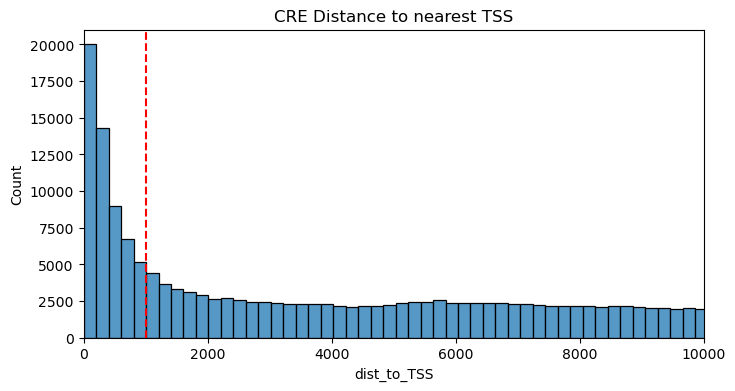

In [4]:
# Plot the distribution of distances to TSS
plt.figure(figsize=(8,4))
plt.xlim(0, 10000)
plt.axvline(x=1000, color='red', linestyle='--')
sns.histplot(peaks["dist_to_TSS"], bins=10000)
plt.title("CRE Distance to nearest TSS")
plt.show()